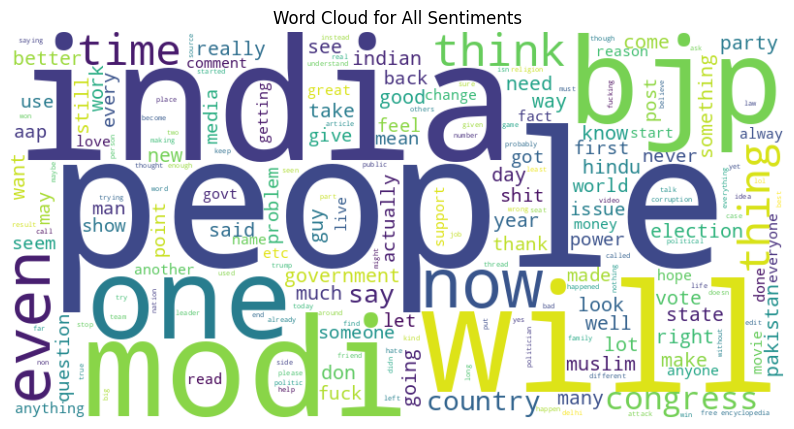

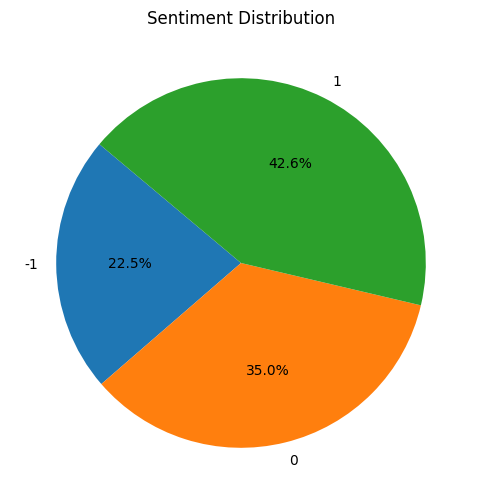

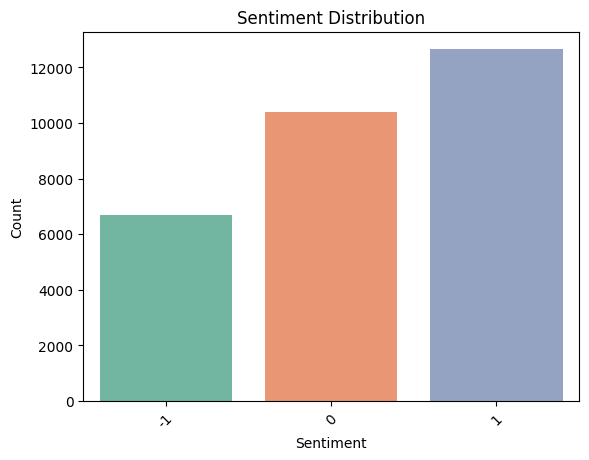

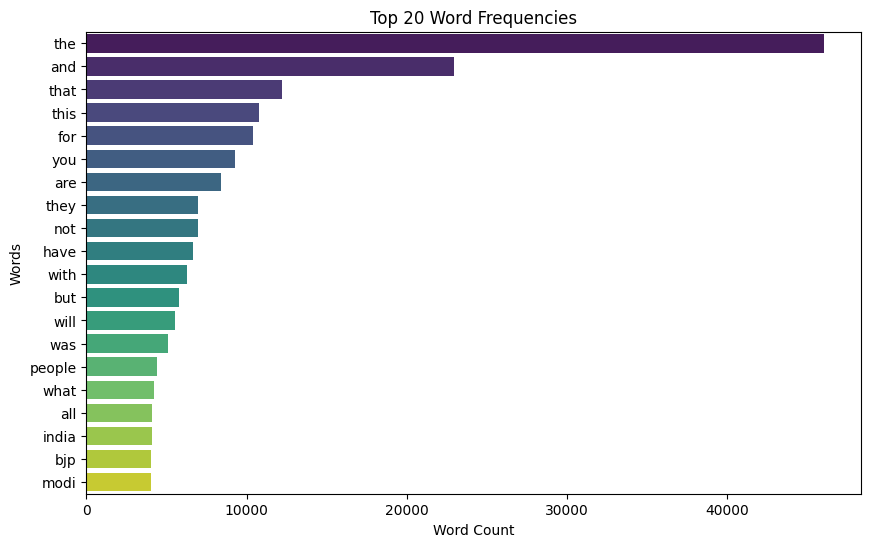

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Reddit_Data.csv')


data.rename(columns={'clean_comment': 'text', 'category': 'sentiment'}, inplace=True)

# Data preprocessing
data.dropna(subset=['text'], inplace=True)  # Drop rows with missing text data

X = data['text']
y = data['sentiment']

# Label encoding for sentiment classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
max_words = 5000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Create word cloud
all_text_combined = ' '.join(X_train)
wordcloud_combined = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(all_text_combined)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for All Sentiments")
plt.show()

# Create a pie chart for sentiment distribution
sentiment_counts = np.bincount(y_train)
sentiment_labels = label_encoder.classes_
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_labels, autopct='%1.1f%%', startangle=140)
plt.title("Sentiment Distribution")
plt.show()

# Create a bar graph for sentiment distribution
sns.countplot(x=y_train, palette="Set2")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
plt.xticks(np.arange(num_classes), sentiment_labels, rotation=45)
plt.show()

word_counts = tokenizer.word_counts
word_counts_sorted = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
top_words = list(word_counts_sorted.keys())[:20]
top_word_counts = list(word_counts_sorted.values())[:20]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_word_counts, y=top_words, palette="viridis")
plt.xlabel("Word Count")
plt.ylabel("Words")
plt.title("Top 20 Word Frequencies")
plt.show()




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

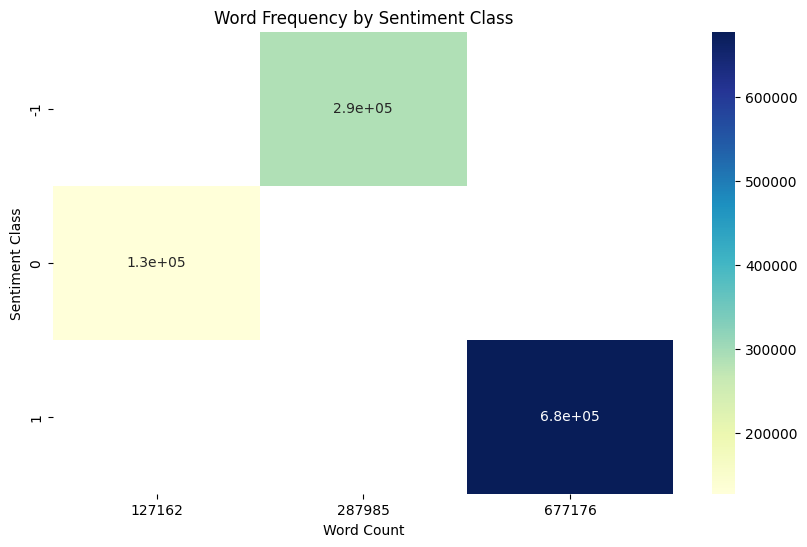

In [ ]:
sentiment_word_freq = data.groupby(['sentiment'])['text'].apply(lambda x: ' '.join(x)).reset_index()
sentiment_word_freq['word_count'] = sentiment_word_freq['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_word_freq.pivot(index='sentiment', columns='word_count', values='word_count'), cmap='YlGnBu', annot=True)
plt.xlabel("Word Count")
plt.ylabel("Sentiment Class")
plt.title("Word Frequency by Sentiment Class")
plt.show()


In [ ]:
# Build an LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_sequence_length))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=64)


Epoch 1/5
465/465 [==============================] - 130s 274ms/step - loss: 0.5855 - accuracy: 0.7643 - val_loss: 0.2906 - val_accuracy: 0.9039
Epoch 2/5
465/465 [==============================] - 129s 278ms/step - loss: 0.2568 - accuracy: 0.9245 - val_loss: 0.2473 - val_accuracy: 0.9248
Epoch 3/5
465/465 [==============================] - 125s 269ms/step - loss: 0.2136 - accuracy: 0.9389 - val_loss: 0.2541 - val_accuracy: 0.9198
Epoch 4/5
465/465 [==============================] - 121s 261ms/step - loss: 0.1871 - accuracy: 0.9463 - val_loss: 0.2581 - val_accuracy: 0.9206
Epoch 5/5
465/465 [==============================] - 123s 264ms/step - loss: 0.1570 - accuracy: 0.9565 - val_loss: 0.2543 - val_accuracy: 0.9280


In [ ]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'Accuracy: {accuracy:.2f}')

233/233 [==============================] - 21s 88ms/step - loss: 0.2338 - accuracy: 0.9291
Accuracy: 0.93


In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_classes = y_pred.argmax(axis=-1)

# Decode the label encoding
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Print classification report
classification_rep = classification_report(y_test_labels, y_pred_labels)
print(classification_rep)


233/233 [==============================] - 11s 42ms/step
              precision    recall  f1-score   support

          -1       0.87      0.85      0.86      1597
           0       0.96      0.96      0.96      2654
           1       0.93      0.93      0.93      3179

    accuracy                           0.93      7430
   macro avg       0.92      0.92      0.92      7430
weighted avg       0.93      0.93      0.93      7430



233/233 [==============================] - 17s 73ms/step


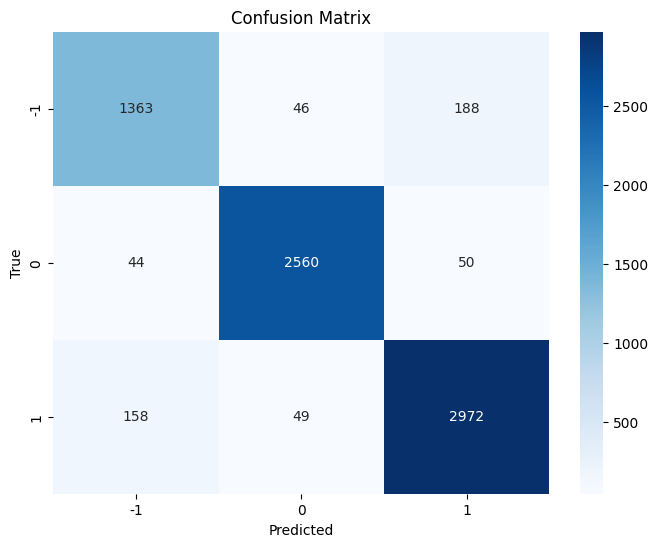

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Generate a confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [ ]:

target_names = list(map(str, label_encoder.classes_))

# Generate a classification report
classification_rep = classification_report(y_test, y_pred_classes, target_names=target_names)
print(classification_rep)


              precision    recall  f1-score   support

          -1       0.87      0.85      0.86      1597
           0       0.96      0.96      0.96      2654
           1       0.93      0.93      0.93      3179

    accuracy                           0.93      7430
   macro avg       0.92      0.92      0.92      7430
weighted avg       0.93      0.93      0.93      7430

